# Example 4.3: Two-layer feedforward network on California Housing Data

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pylab as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection  import train_test_split
from sklearn import preprocessing

## Set the parameters of the network and for learning 

In [2]:
no_features = 8
no_hidden = 10
no_labels = 1

no_epochs = 50
batch_size = 32
lr = 0.001

SEED = 10
torch.manual_seed(SEED)
np.random.seed(SEED)

## Read and preprocess data

In [3]:
X, y = fetch_california_housing(return_X_y=True)

# Split the data into a training set and a test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

print(x_train.shape)
print(y_test.shape)

(14448, 8)
(6192,)


In [4]:
class MyDataset(Dataset):
  def __init__(self, X, y):
    self.X =torch.tensor(X, dtype=torch.float)
    self.y =torch.tensor(y, dtype=torch.float).unsqueeze(1)
    
  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    return self.X[idx], self.y[idx]

train_data = MyDataset(x_train, y_train)
test_data = MyDataset(x_test, y_test)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [5]:
# Define the FFN model and learning

In [6]:
class FFN(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Linear(no_hidden, no_labels),
        )

    def forward(self, x):
        logits = self.relu_stack(x)
        return logits

In [7]:
def train_loop(train_dataloader, model, loss_fn, optimizer):
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()

    train_loss /= size
    return train_loss
    

def test_loop(test_dataloader, model, loss_fn):
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= size
 
    return test_loss
    

In [8]:
model = FFN(no_features, no_hidden, no_labels)

print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")

Model structure: FFN(
  (relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


Layer: relu_stack.0.weight | Size: torch.Size([10, 8]) | Values : Parameter containing:
tensor([[-0.0296, -0.0121, -0.1326,  0.0813, -0.2023, -0.0623,  0.1370,  0.3319],
        [ 0.0833, -0.1199,  0.0339, -0.0396,  0.1443,  0.0405,  0.1385,  0.3429],
        [-0.1468, -0.0125,  0.0813, -0.0023, -0.0339, -0.3129, -0.3050, -0.3181],
        [-0.3459, -0.3293, -0.2678, -0.3189, -0.3317,  0.1550,  0.2169,  0.2389],
        [ 0.1905,  0.1198,  0.1558, -0.1955,  0.3183, -0.0244,  0.3050,  0.1084],
        [ 0.2767,  0.2820, -0.0739, -0.1028,  0.0532, -0.0150,  0.0553,  0.1794],
        [-0.2763, -0.0162, -0.2775,  0.3414, -0.2487,  0.0676, -0.0966,  0.2010],
        [ 0.0012, -0.0356,  0.2588,  0.3229, -0.2566, -0.3410,  0.0295,  0.1114],
        [ 0.0807,  0.3266,  0.1587, -0.1626, -0.2421,  0.2743,  

## Train the network

In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_, test_loss_ = [], []

for epoch in range(no_epochs):
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    
    train_loss_.append(train_loss)
    test_loss_.append(test_loss)
    
    if epoch%10 == 9:
        print(f"Epoch {epoch+1}, train_loss {train_loss:>7f}  test_loss {test_loss:>7f}")
print("Done!")

Epoch 10, train_loss 0.015740  test_loss 0.016918
Epoch 20, train_loss 0.013964  test_loss 0.015363
Epoch 30, train_loss 0.013410  test_loss 0.015100
Epoch 40, train_loss 0.013148  test_loss 0.014625
Epoch 50, train_loss 0.012994  test_loss 0.014413
Done!


## Print final errors

In [10]:
w1 = model.state_dict()['relu_stack.0.weight'].numpy()
b1 = model.state_dict()['relu_stack.0.bias'].numpy()

w2 = model.state_dict()['relu_stack.2.weight'].numpy()
b2 = model.state_dict()['relu_stack.2.bias'].numpy()

print('weight = {}, \nbias = {}\n'.format(w1, b1))
print('weight = {}, \nbias = {}\n'.format(w1, b1))

weight = [[-0.01946063 -0.02692541 -0.07130092  0.1909425  -0.11298238 -0.03531939
   0.10174311  0.41813454]
 [ 0.15897281 -0.12167118  0.02607268 -0.00911553  0.02577551  0.14926212
   0.03398035  0.2357631 ]
 [ 0.1678043   0.10420273 -0.26062733  0.20164768  0.01269102 -0.897811
  -0.8503108  -0.7460771 ]
 [-0.35840988 -0.24402098 -0.24101171 -0.35394812 -0.35253894  0.07852911
   0.2826971   0.20058537]
 [ 0.42325845  0.16409923  0.19822276 -0.11357599  0.23981367 -0.12101953
   0.1160325  -0.02408011]
 [ 0.48040113  0.30611715 -0.04255844  0.02708633  0.08107933 -0.19670072
  -0.05364493 -0.08328556]
 [-0.28049386  0.003088   -0.20686083  0.3857622  -0.24567518  0.0370231
  -0.07477821  0.20701009]
 [ 0.38209096 -0.10486817 -0.00161085  0.07721224 -0.0887445  -0.7692382
  -0.27910534 -0.28378895]
 [ 0.07229674  0.31059697  0.14693041 -0.16644855 -0.2369805   0.25769886
   0.32469893 -0.1400336 ]
 [-0.26843405  0.12258539 -0.18802468 -0.09051596 -0.33348584  0.0426576
  -0.03897391

## Plot learning curves

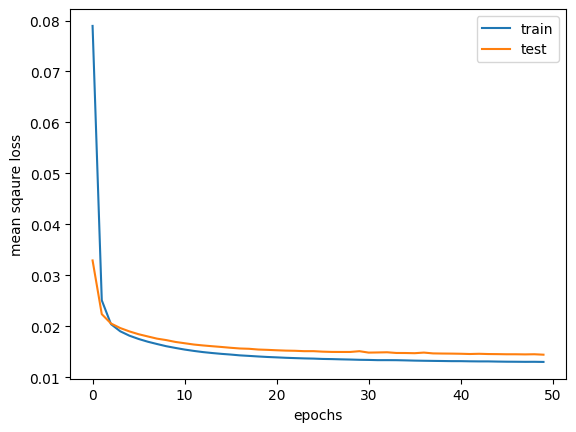

In [11]:
# plot learning curves
plt.figure(1)
plt.plot(range(no_epochs), train_loss_, label='train')
plt.plot(range(no_epochs), test_loss_, label = "test")
plt.xlabel('epochs')
plt.ylabel('mean sqaure loss')
plt.legend()